1. procitati fajl
2. proveriti da li je doslo do saturacije u nekom kanalu
3. digitalno filtriranje
4. eliminisanje spajkova
5. naci maksimum pika
6. naci pocetak pika

In [1]:
from numba import jit
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
f = open('xxxxxxxxx','rb')

1 - struktura fajla - aktivni su bili samo kanali 2 i 3

In [3]:
#little endian
file_header_dtype = np.dtype([
    ("event header", "S4"),            # event header,  4-byte string
    ("serial_number", "<i4"),       # Serial number starting with 1  - integer
    ("year", "<H"),          # svih 8 je unsigned short - 
    ("month", "<H"),
    ("day", "<H"),
    ("hour", "<H"),             
    ("minute", "<H"),            
    ("second", "<H"),             
    ("milisecond", "<H"),
    ("reserved", "<H"),
    ("time_of_sample_bins", ("<f", (1024,))), #1024 4-byte float vreme
    ("channel_header2", "S4"), 
    ("data_channel2", ("<u2", (1024,))), # data 2-byte unsigned int
    ("channel_header3", "S4"),
    ("data_channel3", ("<u2", (1024,))), # data 2-byte unsigned int
   ])


In [4]:
file_header = np.fromfile(f, dtype=file_header_dtype, count=-1)

In [5]:
vreme = file_header["time_of_sample_bins"]

In [6]:
kanal2 = - file_header["data_channel2"]

In [7]:
kanal3 = - file_header["data_channel3"]

In [8]:
print vreme.shape
print kanal2.shape
print kanal3.shape

(124181L, 1024L)
(124181L, 1024L)
(124181L, 1024L)


grafik sa podacima iz jednog kanala sa invertovanim vrednostima napona

C:\Users\PC\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


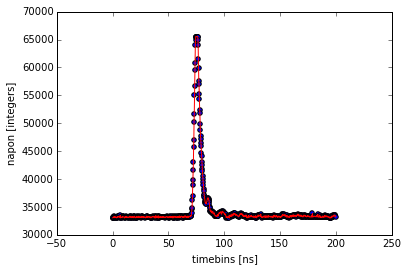

In [9]:
x = vreme[0]
y = kanal2[0]
plt.scatter(x,y)
plt.plot(x, y, 'r')
plt.xlabel('timebins [ns]')
plt.ylabel('napon [integers]')
plt.show()

2 - Provera da li je doslo do saturacije u nekom kanalu

In [10]:
def saturacija(element_kanala):
    return np.count_nonzero(element_kanala == max(element_kanala)) > 2

In [11]:
kanal3_saturacija= np.apply_along_axis(saturacija, 1, kanal3[:])

In [12]:
indeksi_kanal3_saturacija =[ind for ind, x in enumerate(kanal3_saturacija) if x == True]

In [13]:
kanal2_saturacija= np.apply_along_axis(saturacija, 1, kanal2[:])

In [14]:
indeksi_kanal2_saturacija =[ind for ind, x in enumerate(kanal2_saturacija) if x == True]

In [15]:
print len(indeksi_kanal3_saturacija)
print len(indeksi_kanal2_saturacija)

3355
31561


In [16]:
indeksi_za_brisanje = set(indeksi_kanal2_saturacija + indeksi_kanal3_saturacija)

In [17]:
indeksi_za_brisanje_lista = sorted(list(indeksi_za_brisanje))

In [18]:
len(indeksi_za_brisanje_lista)

33421

In [19]:
vreme_bez_saturisanih = np.delete(vreme, indeksi_za_brisanje_lista, 0)

In [20]:
kanal2_bez_saturisanih = np.delete(kanal2, indeksi_za_brisanje_lista, 0)

In [21]:
kanal3_bez_saturisanih = np.delete(kanal3, indeksi_za_brisanje_lista, 0)

In [22]:
print vreme_bez_saturisanih.shape
print kanal2_bez_saturisanih.shape
print kanal3_bez_saturisanih.shape

(90760L, 1024L)
(90760L, 1024L)
(90760L, 1024L)


3 - digitalno filtriranje

In [23]:
@jit
def filtriranje(nefiltrirani):
    filtrirani = np.ones(1024)
    y2, y1 = nefiltrirani[:2]
    filtrirani[0] = nefiltrirani[0]
    filtrirani[1] = nefiltrirani[1]
    for i in range(2,1024):
        y = 0.20657 * nefiltrirani[i] + 0.41314 * nefiltrirani[i-1] \
        + 0.20657 * nefiltrirani[i-2] + 0.36953 * y1 - 0.19582 * y2
        filtrirani[i] = y
        y2 = y1
        y1 = y
    return filtrirani

In [24]:
kanal2_filtrirani = np.apply_along_axis(filtriranje, 1, kanal2_bez_saturisanih[:])

In [25]:
kanal3_filtrirani = np.apply_along_axis(filtriranje, 1, kanal3_bez_saturisanih[:])

4 - eliminisanje spajkova

In [26]:
@jit
def eliminisanje_spajkova(kanal):
    
    for i in range(30):
        kanal[i] = (kanal[51+i] + kanal[52+i] + kanal[53+i] + kanal[54+i] + \
                    kanal[55+i] + kanal[56+i] + kanal[57+i] + kanal[58+i]) / 8
    for i in range(30,1000):
        kanal[i] = (kanal[i-6] + kanal[i-5] + kanal[i-4] + kanal[i-3] + \
                    kanal[i-2] + kanal[i-1] + kanal[i] + kanal[i+1] + kanal[i+2] + \
                    kanal[i+3] + kanal[i+4] + kanal[i+5] + kanal[i+6]) / 13
    for i in range(1000,1024):
        kanal[i] = (kanal[851] + kanal[852] + kanal[853] + kanal[854] + \
                    kanal[855] + kanal[856] + kanal[857] + kanal[858]) / 8
    return kanal

In [27]:
kanal2_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal2_filtrirani[:])

In [28]:
kanal3_filtrirani_i_eliminisani_spajkovi = np.apply_along_axis(eliminisanje_spajkova, 1, kanal3_filtrirani[:])

5 - maksimum pika

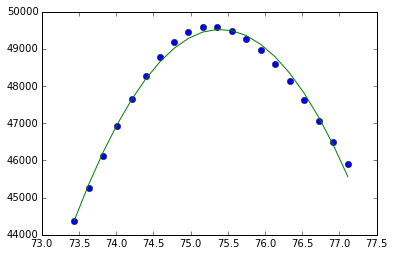

In [29]:
#primer fita za maksimum pika


#numpy.polyfit performs a least squares polynomial fit
#poly1d calculates the new points
#maksimum daje indeks maksimalne vrednosti i od te tacke uzimam 10 sa leve i 10 sa desne strane za fit


def grafik_fita(vreme, kanal):
    maksimum = kanal.argmax()
    donji_indeks = maksimum - 10
    gornji_indeks = maksimum + 10
    x = vreme[donji_indeks:gornji_indeks]
    y = kanal[donji_indeks:gornji_indeks]
    koeficijenti = np.polyfit(x, y, 2)
    f = np.poly1d(koeficijenti)
    y_new = f(x)
    plt.plot(x, y, 'o')
    plt.plot(x, y_new, '-')
    plt.show()
    
    
grafik_fita(vreme[9824],kanal2_filtrirani_i_eliminisani_spajkovi[9824] )



6 - Pocetak pika

In [30]:
#inicijalne vrednosti koeficijenata za prave
a,b,c,d = 1,1,1,1

def fitovanje(vreme,kanal):
    indeks_maksimuma = kanal.argmax()
    minimum = min(kanal)
    #indeks_minimuma = kanal.argmin()
    #minimum = kanal[indeks_minimuma]
    donji_indeks = indeks_maksimuma - 10
    gornji_indeks = indeks_maksimuma + 10
    x = vreme[donji_indeks:gornji_indeks]
    y = kanal[donji_indeks:gornji_indeks]
    koeficijenti = np.polyfit(x, y, 2)
    f = np.poly1d(koeficijenti)
    y_novo = f(x)
    
    return max(y_novo), minimum


# dve tacke za pravu koja sece X osu (20% i 80% maksimuma funkcije) i prava kroz njih

def prava_kroz_02maks_i_08maks(maksimum, minimum, vreme, kanal):
    razlika = maksimum - minimum
    donja_prava = razlika * 0.2 + minimum
    gornja_prava = razlika * 0.8 + minimum

    index_y1 = np.argmax(kanal > donja_prava)
    value_y1 = kanal[index_y1]
    value_x1 = vreme[index_y1]

    index_y2 = np.argmax(kanal > gornja_prava)
    value_y2 = kanal[index_y2]
    value_x2 = vreme[index_y2]

    Y_koordinate_tacaka = [value_y1, value_y2]
    X_koordinate_tacaka = [value_x1, value_x2]
    
    a,b = np.polyfit(X_koordinate_tacaka, Y_koordinate_tacaka, 1)
    #y = a * x + b
    #y_new = a*vreme + b
    #plt.plot(vreme, kanal, 'o')
    #plt.plot(vreme, y_new, '-')
    #plt.show()
    return a,b


# prava kroz pocetak grafika pre pika
# koeficijenti pravca prave c, d

def prava_kroz_Xosu(x,y):  
    indeksi_tacaka_za_fit = (x > min(x)) & (x < 30.0)
    x_tacke = x[indeksi_tacaka_za_fit]
    y_tacke = y[indeksi_tacaka_za_fit] 
    c,d = np.polyfit(x_tacke, y_tacke, 1)
    #y_new = c*vreme + d
    #plt.plot(vreme, y_new, '-')
    #plt.show()
    #y = c * x + d
    return c,d



#tacka preseka dve prave tj vreme pocetka impulsa
def presek_pravih(input_vector):
    x,y = input_vector
    z = np.array([y - x*a - b, y - x*c - d])
    return z



def pocetak_impulsa(vreme, kanal):
    global a, b, c, d
    maksimum, minimum  = fitovanje(vreme,kanal)
    a,b = prava_kroz_02maks_i_08maks(maksimum, minimum, vreme, kanal)
    c,d = prava_kroz_Xosu(vreme, kanal)
    return fsolve(presek_pravih, [60.0, 0.0])[0]
    
    

In [32]:
t_2 = np.array([])
t_3 = np.array([])

for i in range(kanal2_filtrirani_i_eliminisani_spajkovi.shape[0]):
    try:
        result2 = pocetak_impulsa(vreme[i], kanal2_filtrirani_i_eliminisani_spajkovi[i])
        result3 = pocetak_impulsa(vreme[i], kanal3_filtrirani_i_eliminisani_spajkovi[i])
        t_2 = np.append(t_2, result2)
        t_3 = np.append(t_3, result3)
        
    except TypeError:
        pass
    


In [33]:
t_2.shape

(90759L,)

In [34]:
t_3.shape

(90759L,)

In [35]:
delta_t = t_2 - t_3

In [38]:
#svi van -2. < x < 2.
broj_van_opsega_2 = [ind for ind, x in enumerate(delta_t) if ((x < - 2.) or (x > 2.))]

In [43]:
len(broj_van_opsega_2)

165

In [44]:
delta_t_bez_ekstrema = np.delete(delta_t, broj_van_opsega_2, 0)

In [45]:
mean = np.mean(delta_t_bez_ekstrema)
variance = np.var(delta_t_bez_ekstrema)
sigma = np.sqrt(variance)

print mean, sigma

-0.220060254185 0.27867789058


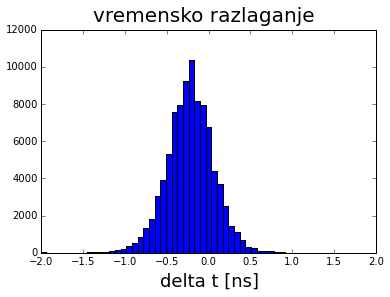

In [46]:
#np.histogram([1, 2, 1], bins=[0, 1, 2, 3])
plt.hist(delta_t_bez_ekstrema, bins=np.linspace(-2.0, 2.0, num=60))
plt.suptitle('vremensko razlaganje', fontsize=20)
plt.xlabel('delta t [ns]', fontsize=18)
#plt.ylabel('ylabel', fontsize=16)
plt.show()
